In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random #generating negative random numbers

from mpl_toolkits.mplot3d import Axes3D # for 3D visualization

from tqdm import tqdm, trange #loading status


## Dendpoint generation in 2D

In [148]:
Ldend = 180
soma = np.zeros(3)
soma= np.array([-150,-300,0])

DEBUG=False

def debug_print(*s):
    if DEBUG:
        print(*s)
    else:
        pass

def make_random_dend_ends():
    angle0 = np.random.rand()*np.pi/2
    debug_print("Starting Point",angle0) #random starting point
    # first 3 angles between dends
    angles3 = np.ones(3)*np.pi/2
    angles = np.cumsum(angles3) 
    angles = np.hstack([0, angles]) + angle0 

    #adding more variability for each point independent from the others
    r=np.random.uniform(-0.5, 0.5,4)
    angles=angles+r
    debug_print("Single Point Variation=", r)

    #produce x and y coordinates
    return np.array([[Ldend*np.cos(a), Ldend*np.sin(a)] for a in angles]) # cos=x; sin=y
    
point1_xz = make_random_dend_ends()               
print(point1_xz)

print(soma)
point1_xz = point1_xz + soma[:2]               

print(point1_xz)




[[ 160.99413539   80.50396493]
 [ -83.62861391  159.39339677]
 [-129.66433155 -124.84855275]
 [ 163.98181761  -74.22912833]]
[-150 -300    0]
[[  10.99413539 -219.49603507]
 [-233.62861391 -140.60660323]
 [-279.66433155 -424.84855275]
 [  13.98181761 -374.22912833]]


In [149]:
#circle
theta = np.linspace( 0 , 2 * np.pi , 170 )  
radius = Ldend #ToDO automate: point -soma?
Ca = radius * np.cos( theta )+soma[0]
Cb = radius * np.sin( theta )+soma[1]

In [150]:
# upper and lower borders (y= mx+n)
xlay=np.linspace(-500,150,150)
upperLimit=-250 #MLI layer border
lowerLimit=-75 #MLI layer border
up=0*xlay+upperLimit
down=0*xlay+lowerLimit

In [151]:
##Check if upper layer limit collides with dendrite radius around soma
#calculate distance between layer and soma
d=abs(soma[1]-upperLimit)
print(d)
if d < radius:
    print("Dendrites might interfere with layer limit")
elif d <= radius:
    print("Dendrites might reach layer limit")
else:
    print("There is enough space for dendrites")



50
Dendrites might interfere with layer limit


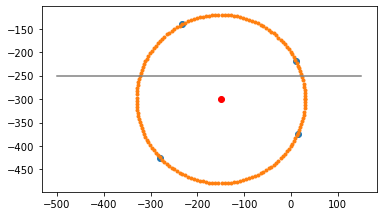

In [152]:
#plot
figure, axes= plt.subplots(1)

axes.plot(point1_xz[:,0], point1_xz[:,1], 'o')
axes.plot(soma[0],soma[1], 'or')

axes.plot(Ca,Cb, ".")
axes.plot(xlay,up, "grey")
#axes.plot(xlay,down, "grey")
axes.set_aspect(1)

In [153]:
#check which dendrite is outside of the layer and correct its position
def fix_dend_ends_upper(point1_xz, soma, upperLimit, push_down=100):
    
    d=abs(soma[1]-upperLimit)
    
    point1_xz_new = np.zeros_like(point1_xz)
    for i in range(point1_xz.shape[0]):
        x, y=point1_xz[i];
        
        #print(point1_xz[i]);
        if y>soma[1]+d:
            debug_print("Dendrite",i, "is outside the layer:", point1_xz[i]);
            if point1_xz[i,0]< soma[0]:       # make sure each dendrite goes to one one side
                y=soma[1]+d- np.random.uniform(0, push_down); #soma y coord. plus the distance to layer+ variability 
                point1_xz_new[i,1]=y
                phi=np.arcsin((y-soma[1])/radius) # calculate phi for new x
                x1=radius*np.cos(phi)+soma[0]     # new x coord. on layer
                point1_xz_new[i,0]=soma[0]-(x1-soma[0]) 
            else:
                y=soma[1]+d- np.random.uniform(0, push_down); #soma y coord. plus the distance to layer
                phi=np.arcsin((y-soma[1])/radius) # calculate phi for new x
                x1=radius*np.cos(phi)+soma[0]     # new x coord. on layer
                point1_xz_new[i,:]=[x1, y]
            debug_print("New Coordinates", point1_xz[i])
        else:
            debug_print("Dendrite",i, "is inside the layer ")
            point1_xz_new[i,:]= [x, y]

    return point1_xz_new


point1_xz_new = fix_dend_ends_upper(point1_xz, soma, -250)

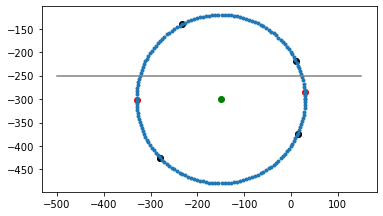

In [154]:
#plot
figure, axes= plt.subplots(1)

axes.plot(point1_xz_new[:,0], point1_xz_new[:,1], 'or')
axes.plot(point1_xz[:,0], point1_xz[:,1], 'ok')
axes.plot(soma[0],soma[1], 'og')
axes.plot(Ca,Cb, ".")
axes.plot(xlay,up, "grey")
#axes.plot(xlay,down, "grey")
axes.set_aspect(1)

## Check distance to other EndPoints

Add points between Soma and EndPoint

In [11]:
#calculate x values for points between soma and endpoint
#xDendAll=np.empty((0,0), dtype=object)
def dend_points_soma_endpoint(point1_xz_new, soma, nPoint=90):
    xDendAll = np.zeros(shape=(0))
    yDendAll = np.zeros(shape=(0))
    for i in range(point1_xz_new.shape[0]):
        #nPoint= 90
        xLen=abs(soma[0]-point1_xz_new[i,0]) # length of dendrite on x axis
        xComp= xLen/nPoint # distance of compartments on x axis
        if point1_xz_new[i,0] < soma[0]:
            xDend=(np.cumsum(np.ones(nPoint-1)*xComp))+ point1_xz_new[i,0]#soma[0]
            xDendAll = np.append(xDendAll, xDend, axis=0)
        else:
            xDend=(np.cumsum(np.ones(nPoint-1)*xComp))+soma[0]
            xDendAll = np.append(xDendAll, xDend, axis=0)
        #calculating slope
        m=(soma[1]-point1_xz_new[i,1])/(soma[0]-point1_xz_new[i,0]) #m=(y1-y2)/(x1-x2)
        #function for calculating y
        yDend=np.array((m*xDend)-(m*soma[0])+soma[1])
        
        yDendAll = np.append(yDendAll, yDend, axis=0)
    
    return xDendAll, yDendAll
        
xDendAll,yDendAll = dend_points_soma_endpoint(point1_xz_new, soma)


#TODO: case for vertical line?

    


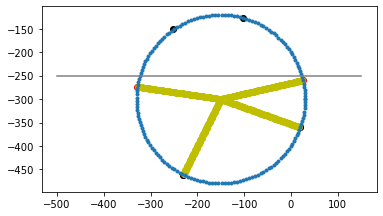

In [12]:
#plot
figure, axes= plt.subplots(1)

axes.plot(point1_xz_new[:,0], point1_xz_new[:,1], 'or')
axes.plot(point1_xz[:,0], point1_xz[:,1], 'ok')
axes.plot(soma[0],soma[1], 'og')
axes.plot(xDendAll[:],yDendAll[:],'oy')
axes.plot(Ca,Cb, ".")
axes.plot(xlay,up, "grey")
#axes.plot(xlay,down, "grey")
axes.set_aspect(1)

## ADD MORE SOMA

In [156]:
soma = np.zeros((100,3))
somas = np.array([np.random.uniform(-600,600,3) for i in soma]) # cos=x; sin=y
somas[:,0] = np.random.uniform(-600, 600, size=100)
somas[:,1] = np.random.uniform(20, 180, size=100)


print("We generated", len(somas), "somas.")

We generated 100 somas.


In [172]:
# upper and lower borders (y= mx+n)
xlay=np.linspace(-600,600,600)
upperLimit=max(somas[:,1])+20 #MLI layer border
lowerLimit=min(somas[:,1]-20) #MLI layer border

#upperLimit= 200 #MLI layer border
up=0*xlay+upperLimit
down=0*xlay+lowerLimit

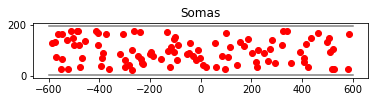

In [158]:
figure, axes= plt.subplots(1)

#axes.plot(point1_xz[:,0], point1_xz[:,1], 'o')
#axes.plot(Ca,Cb, ".")
axes.plot(somas[:,0],somas[:,1] ,'or')
axes.plot(xlay,up, "grey")
axes.plot(xlay,down, "grey")


axes.set_aspect(1)
plt.title("Somas");

In [175]:
##generate endpoints around respective somas
EpointDendx=np.empty((0,2), dtype=object) #empty array for dendrites
EpointDend=np.empty((0,2), dtype=object) #empty array for dendrites
xDendAllAll=np.empty((0), dtype=object) #empty array for dendrites
yDendAllAll=np.empty((0), dtype=object) #empty array for dendrites

for s in range(somas.shape[0]):
    
    soma = somas[s,:2]
    point1_xz = make_random_dend_ends() + soma
    point1_xz_new = fix_dend_ends_upper(point1_xz, soma, upperLimit)
    point1_xz_new = -fix_dend_ends_upper(-point1_xz_new, -soma, lowerLimit)
    xDendAll,yDendAll = dend_points_soma_endpoint(point1_xz_new, soma)
    

    EpointDendx = np.append(EpointDendx, point1_xz, axis=0)
    EpointDend = np.append(EpointDend, point1_xz_new, axis=0)
    
    xDendAllAll = np.append(xDendAllAll, xDendAll, axis=0)
    yDendAllAll = np.append(yDendAllAll, yDendAll, axis=0)

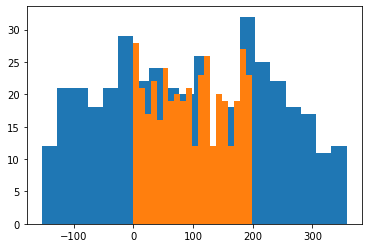

In [176]:
plt.hist(EpointDendx[:,1], 20);
plt.hist(EpointDend[:,1], 20);

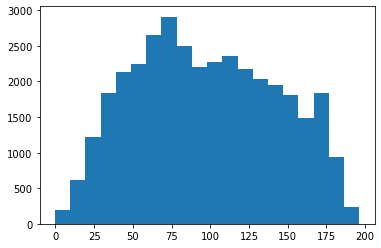

In [177]:
#plt.hist(xDendAllAll[:], 20);
plt.hist(yDendAllAll[:], 20);

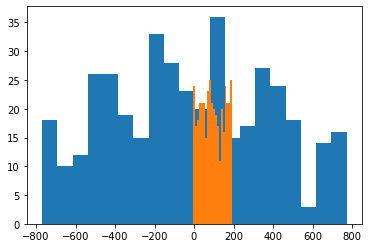

In [27]:
plt.hist(EpointDend[:,0],20);
plt.hist(EpointDend[:,1],20);


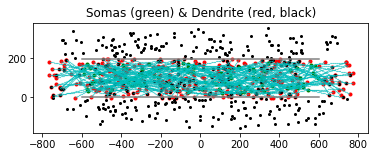

In [24]:
def plot_one_skeleton(soma, pointDend, axes):
    for i in range(pointDend.shape[0]):
        dend_point = pointDend[i, :]
        axes.plot([soma[0], dend_point[0]], [soma[1], dend_point[1]], ':k')

def plot_skeletons(somas, point_dends, axes):
    for s in range(somas.shape[0]):
        soma = somas[s,:2]
        point_dends_1 = point_dends[(s*4):((s+1)*4),:]
        plot_one_skeleton(soma, point_dends_1, axes)
        
figure, axes= plt.subplots(1)

axes.plot(EpointDend[:,0], EpointDend[:,1], 'or', markersize=3)
axes.plot(EpointDendx[:,0], EpointDendx[:,1], 'ok', markersize=2)
axes.plot(somas[:,0],somas[:,1] ,'og', markersize=3)
#plot_skeletons(somas, EpointDend, axes)
axes.plot(xDendAllAll[:], yDendAllAll[:],"oc", markersize=0.1)
    
axes.plot(xlay,up, "grey")
axes.plot(xlay,down, "grey")


axes.set_aspect(1)
plt.title("Somas (green) & Dendrite (red, black)");

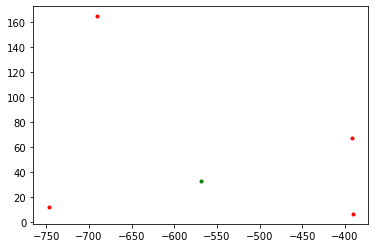

In [31]:
figure, axes= plt.subplots(1)

axes.plot(EpointDend[:4,0], EpointDend[:4,1], 'or', markersize=3)
axes.plot(somas[:1,0],somas[:1,1] ,'og', markersize=3)


## WHAT ABOUT 3D?

In [ ]:
#%matplotlib notebook

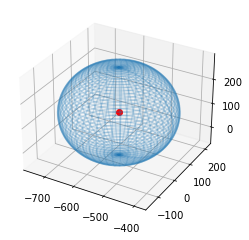

In [32]:
#plotting sphere

phi = np.linspace(0, np.pi, 50)
theta = np.linspace(0, 2*np.pi, 50)
phi, theta = np.meshgrid(phi, theta)

x = np.sin(phi) * np.cos(theta) * Ldend +somas[0,0]
y = np.sin(phi) * np.sin(theta)* Ldend +somas[0,1]
z = np.cos(phi) *Ldend + somas[0,2]


fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, alpha=0.2)
ax.plot(somas[0,0], somas[0,1], somas[0,2],'or')



ax.set_aspect("auto")




plt.show()

### Random perturbation in z-axis

In [33]:
EpointDend.shape

(400, 2)

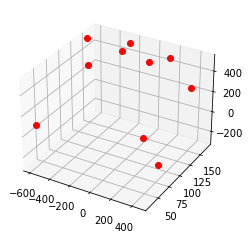

In [36]:
fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection='3d')
ax.plot(somas[:10,0], somas[:10,1], somas[:10,2],'or')

In [40]:
EpointDend3 = np.zeros((EpointDend.shape[0], 3))
EpointDend3[:, 0:2] = EpointDend
for i in range(somas.shape[0]):
    EpointDend3[(4*i):(4*(i+1)), 2] = somas[i, 2]

In [50]:
EpointDend3.shape

(400, 3)

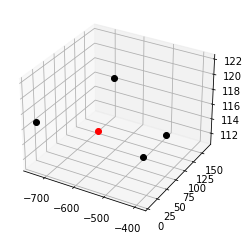

In [41]:
fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection='3d')
ax.plot(somas[:1,0], somas[:1,1], somas[:1,2],'or')
ax.plot(EpointDend3[:4,0], EpointDend3[:4,1], EpointDend3[:4,2],'ok')
#for ii in range(0,360,1):
 #   ax.view_init(elev=5., azim=ii)
  #  plt.savefig("movie_figs/movie%d.png" % ii)

In [46]:
somas[0:4]

array([[-568.6113449 ,   32.7278493 ,  116.5298205 ],
       [ -33.68478138,  146.64532227, -313.96953314],
       [-344.34879078,   93.81240161,  518.65541321],
       [-588.83938267,  144.75912226,  541.63609922]])

In [47]:
## 3rd coordinate for Endpoints for only one soma
sigma = 24

ep1 = EpointDend[:4,:] - somas[0,:2]
ep1_3d = np.zeros((4,3))
ep1_3d[:,:2] = ep1
ep1_3d[:, 2] = np.random.randn(4)*sigma


#adjust distance to soma back to Ldend(=180)
for i in range(4):
    norm = np.sqrt(ep1_3d[i,0]**2 + ep1_3d[i,1]**2 + ep1_3d[i,2]**2) 
    ep1_3d[i,:] = ep1_3d[i,:]/norm*Ldend
   
ep1_3d = ep1_3d + somas[0,:]

In [49]:
ep1_3d

(4, 3)

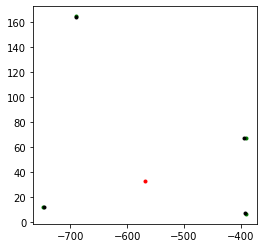

In [54]:
fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111)
ax.plot(somas[0,0], somas[0,1],'.r')
ax.plot(EpointDend[:4,0], EpointDend[:4,1],'.g')
ax.plot(ep1_3d[:,0], ep1_3d[:,1],'.k')


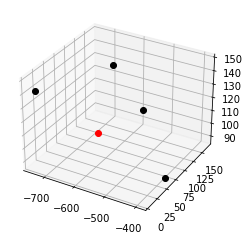

In [55]:
fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection='3d')
ax.plot(somas[0,0], somas[0,1], somas[0,2],'or')
ax.plot(ep1_3d[:,0], ep1_3d[:,1], ep1_3d[:,2],'ok')

In [61]:
EpointDend[:4]

array([[-392.0086895274221, 67.53448826612168],
       [-690.9335526103207, 164.77813328868336],
       [-747.4305031674942, 12.143665181128611],
       [-390.5224296697817, 6.567989353054797]], dtype=object)

In [62]:
EpointDend3[:4]

array([[-392.00868953,   67.53448827,  116.5298205 ],
       [-690.93355261,  164.77813329,  116.5298205 ],
       [-747.43050317,   12.14366518,  116.5298205 ],
       [-390.52242967,    6.56798935,  116.5298205 ]])

In [63]:
def make_dend_ends_3d(somas, EpointDend):
    ep1_3d_All=np.empty((0,3), dtype=object) #empty array for dendrites
    sigma = 24
    
    for s in range(somas.shape[0]):
        soma = somas[s,:]

        ep1 = EpointDend[(s*4):((s+1)*4),:] - somas[s,:2]
        ep1_3d = np.zeros((4,3))
        ep1_3d[:,:2] = ep1
        ep1_3d[:, 2] = np.random.randn(4)*sigma

        #print(ep1_3d)

        for i in range(4):
            norm = np.sqrt(ep1_3d[i,0]**2 + ep1_3d[i,1]**2 + ep1_3d[i,2]**2)
            ep1_3d[i,:3] = ep1_3d[i,:3]/norm*Ldend
        ep1_3d = ep1_3d[:,:3] + somas[s,:]
        ep1_3d_All=np.append(ep1_3d_All, ep1_3d, axis=0)
        #print(EpointDend[(s*4):((s+1)*4),:])
        
    return ep1_3d_All
    
ep1_3d_All=make_dend_ends_3d(somas, EpointDend)

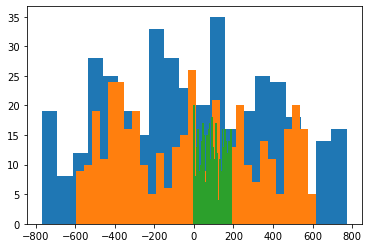

In [80]:
plt.hist(ep1_3d_All[:,0],20);
plt.hist(ep1_3d_All[:,2],30);
plt.hist(ep1_3d_All[:,1],30);

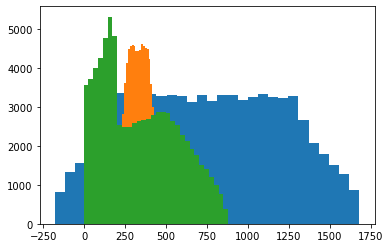

In [224]:
plt.hist(ep1_3d_All[:,0],30);
plt.hist(ep1_3d_All[:,2],30);
plt.hist(ep1_3d_All[:,1],30);

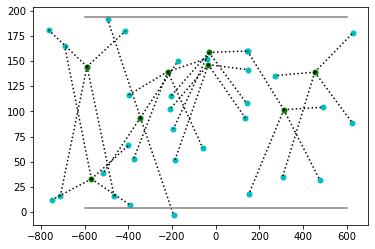

In [81]:
figure, axes= plt.subplots(1)


axes.plot(ep1_3d_All[:32,0], ep1_3d_All[:32,1], 'oc', markersize=5)
axes.plot(somas[:8,0],somas[:8,1],'og', markersize=5)
plot_skeletons(somas[0:8], ep1_3d_All[0:32], axes)
#axes.plot(xDendAllAll[:], yDendAllAll[:],"oc", markersize=0.1)
    
axes.plot(xlay,up, "grey")
axes.plot(xlay,down, "grey")

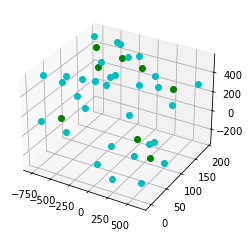

In [82]:
fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection='3d')
ax.plot(somas[0:8,0], somas[0:8,1], somas[0:8,2],'og')
ax.plot(ep1_3d_All[:32,0], ep1_3d_All[:32,1], ep1_3d_All[:32,2],'oc')
plot_skeletons(somas[0:8], ep1_3d_All[0:32], axes)

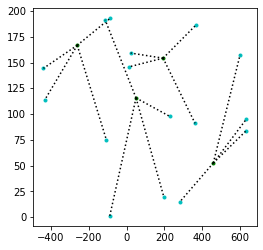

In [83]:
fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111)
for s in range(8,12):
    ax.plot(somas[s,0], somas[s,1],'.g')
    #ax.plot(EpointDend[:,0], EpointDend[:,1],'.c')
    ax.plot(ep1_3d_All[(s*4):((s+1)*4),0], ep1_3d_All[(s*4):((s+1)*4),1],'.c')
    for d in range(4):
        ax.plot([somas[s,0], ep1_3d_All[(s*4+d), 0]],
                [somas[s,1], ep1_3d_All[(s*4+d), 1]], ':k')



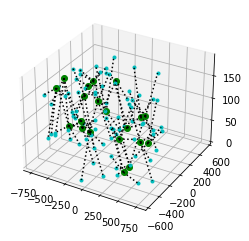

In [85]:
from tqdm import tqdm, trange

fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection='3d')
for s in range(10,30):
    ax.plot(somas[s,0], somas[s,2], somas[s,1], 'og')
    #ax.plot(EpointDend[:,0], EpointDend[:,1],'.c')
    ax.plot(ep1_3d_All[(s*4):((s+1)*4),0], 
            ep1_3d_All[(s*4):((s+1)*4),2],
            ep1_3d_All[(s*4):((s+1)*4),1], '.c')
    for d in range(4):
        ax.plot([somas[s,0], ep1_3d_All[(s*4+d), 0]],
                [somas[s,2], ep1_3d_All[(s*4+d), 2]],
                [somas[s,1], ep1_3d_All[(s*4+d), 1]], ':k')

#for ii in trange(0,360,1):
 #   ax.view_init(elev=5., azim=ii)
  #  plt.savefig("movie_figs/movie%d.png" % ii)

In [ ]:
ls

## Generate Dendrite points

In [86]:
def generate_DendPoint_3d(soma, ep1_3d, nPoint=90):
    DendPointAll= np.empty((0,3),dtype=object)

    for i in range(ep1_3d.shape[0]):
        VectorSoEp= ep1_3d[i]-soma #calculate the vector from soma to endpoint
        for s in range(nPoint):
            DendPoint= np.array(soma+ VectorSoEp/nPoint*s) # vector soma + vectorsomaendpoint shortened
            DendPointAll = np.vstack((DendPointAll,DendPoint))
            
    return DendPointAll

DendPointAll=generate_DendPoint_3d(somas[0], ep1_3d)


In [88]:
DendPointAll.shape

(360, 3)

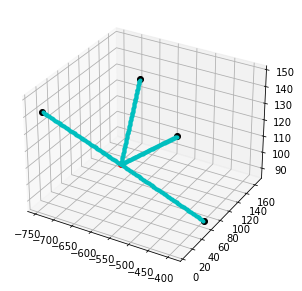

In [89]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot(somas[0,0], somas[0,1], somas[0,2],'or')
ax.plot(ep1_3d[:,0], ep1_3d[:,1], ep1_3d[:,2],'ok')
#ax.plot(DendPoint[0], DendPoint[1],DendPoint[2],"oc", markersize=3)
ax.plot(DendPointAll[:,0], DendPointAll[:,1],DendPointAll[:,2],"oc", markersize=3)




#for ii in trange(0,360,1):
 #   ax.view_init(elev=5., azim=ii)
  #  plt.savefig("movie_figs/movie%d.png" % ii)

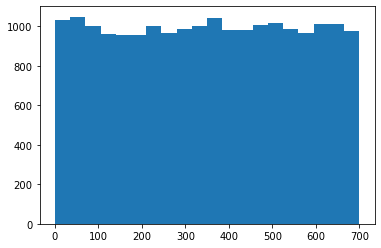

In [222]:
plt.hist(somas[:,1], 20);

In [119]:
somas = np.loadtxt('test_data/MLI_20000/MLIcoordinates.dat')

In [96]:
##generate endpoints around respective somas
DendPointAllAll=np.empty((0,3), dtype=object) #empty array for dendrites


for s in range(somas.shape[0]):
    soma = somas[s]
    DendPointAll=(generate_DendPoint_3d(soma,ep1_3d_All[s*4:(s+1)*4]))
    
    DendPointAllAll = np.vstack((DendPointAllAll, DendPointAll))


In [97]:
DendPointAllAll.shape[0]/somas.shape[0]

360.0

In [98]:
somas.shape

(100, 3)

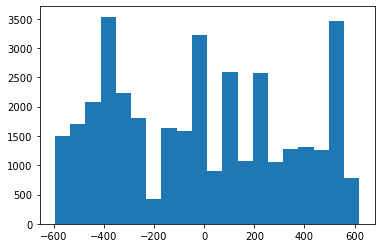

In [103]:
plt.hist(DendPointAllAll[:,2], 20);

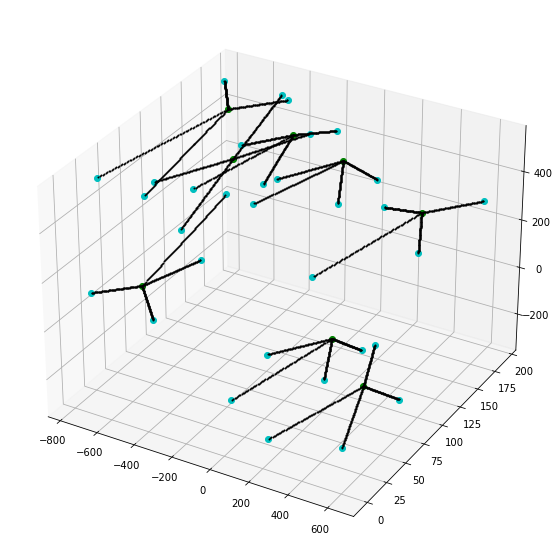

In [104]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(somas[:8,0], somas[:8,1], somas[:8,2],'og')
ax.plot(ep1_3d_All[:32,0], ep1_3d_All[:32,1], ep1_3d_All[:32,2],'oc')
#ax.plot(DendPoint[0], DendPoint[1],DendPoint[2],"oc", markersize=3)
ax.plot(DendPointAllAll[:2880,0], DendPointAllAll[:2880,1],DendPointAllAll[:2880,2],"ok", markersize=1)

#for ii in trange(0,360,1):
 #   ax.view_init(elev=5., azim=ii)
  #  plt.savefig("movie_figs/movie%d.png" % ii)

## Generate All Endpoints for even more soma

In [ ]:
cd

In [109]:
cd ComputationalNeuroscienceUnit/pycabnn-MLI/

/Users/reuschenbachjosefine/ComputationalNeuroscienceUnit/pycabnn-MLI


In [207]:
somas = np.loadtxt('test_data/MLI_20000/MLIcoordinates.dat')

In [208]:
somas.shape

(19885, 3)

In [226]:
max(somas[:,1])

699.998768292589

In [225]:
upperLimit

198.19066703461442

In [257]:
##generate endpoints around respective somas
EpointDendx=np.empty((0,2), dtype=object) #empty array for dendrites
EpointDend=np.empty((0,2), dtype=object) #empty array for dendrites
xDendAllAll=np.empty((0), dtype=object) #empty array for dendrites
yDendAllAll=np.empty((0), dtype=object) #empty array for dendrites

for s in range(somas.shape[0]):
    
    soma = somas[s,:2]
    point1_xz = make_random_dend_ends() + soma
    point1_xz_new = fix_dend_ends_upper(point1_xz, soma, upperLimit=200)
    point1_xz_new = -fix_dend_ends_upper(-point1_xz_new, -soma, lowerLimit)
    xDendAll,yDendAll = dend_points_soma_endpoint(point1_xz_new, soma)
    

    EpointDendx = np.append(EpointDendx, point1_xz, axis=0)
    EpointDend = np.append(EpointDend, point1_xz_new, axis=0)
    
    xDendAllAll = np.append(xDendAllAll, xDendAll, axis=0)
    yDendAllAll = np.append(yDendAllAll, yDendAll, axis=0)

In [258]:
point1_xz

array([[1457.58858797,  462.73290077],
       [1269.38691004,  368.538114  ],
       [1378.56801737,  112.20748118],
       [1604.78661559,  247.01287196]])

In [259]:
point1_xz_new

array([[1596.90020564,  349.53252376],
       [1269.38691004,  368.538114  ],
       [1378.56801737,  112.20748118],
       [1604.78661559,  247.01287196]])

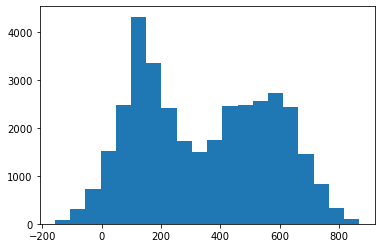

In [260]:
plt.hist(yDendAllAll[:],20);

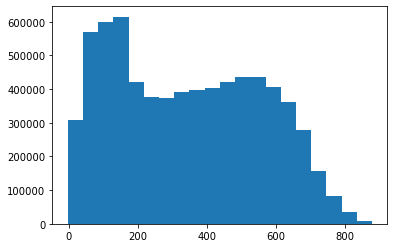

In [144]:
plt.hist(yDendAllAll[:],20);

In [270]:
plt.hist(EpointDend[:,2],20);

IndexError: index 2 is out of bounds for axis 1 with size 2

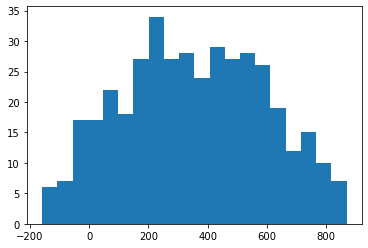

In [267]:
plt.hist(EpointDendx[:,1],20);

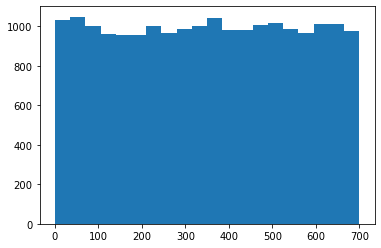

In [227]:
plt.hist(somas[:,1],20);

In [115]:
ep1_3d_All=make_dend_ends_3d(somas, EpointDend)

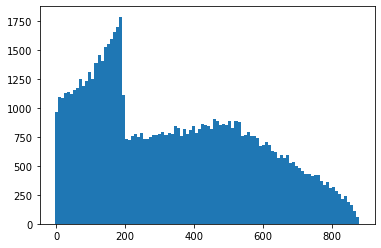

In [187]:
plt.hist(ep1_3d_All[:,1], 100);

In [206]:
print(min(ep1_3d_All[:,0]), min(somas[:,0]))

print(max(ep1_3d_All[:,0]), max(somas[:,0]))

-178.93357722298697 0.02002983060930319
1679.468765760554 1499.9633035404645


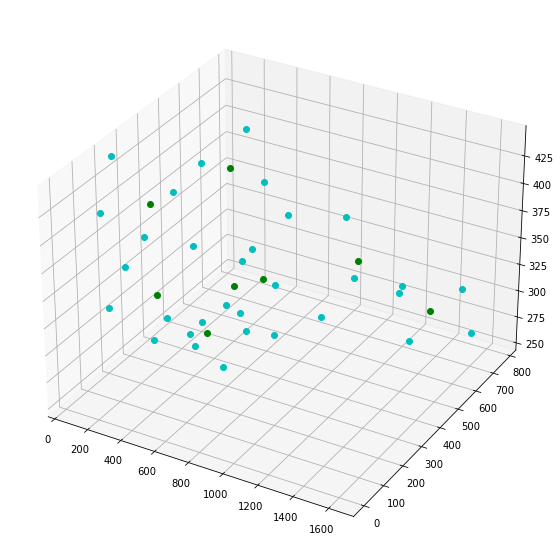

In [201]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(somas[:8,0], somas[:8,1], somas[:8,2],'og')
ax.plot(ep1_3d_All[:32,0], ep1_3d_All[:32,1], ep1_3d_All[:32,2],'oc')

In [116]:
DendPointAll=generate_DendPoint_3d(somas[0], ep1_3d)

In [117]:
##generate endpoints around respective somas
DendPointAllAll=np.empty((0,3), dtype=object) #empty array for dendrites


for s in range(somas.shape[0]):
    soma = somas[s]
    DendPointAll=(generate_DendPoint_3d(soma,ep1_3d_All[s*4:(s+1)*4]))
    
    DendPointAllAll = np.vstack((DendPointAllAll, DendPointAll))

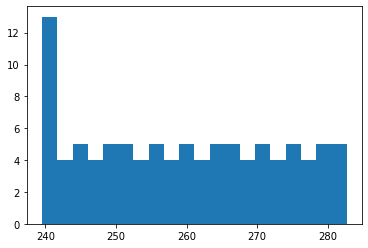

In [121]:
plt.hist(DendPointAllAll[:100,1], 20);

In [ ]:
!open .

In [ ]:
DendPointAllAll.shape

## Adding ID of Soma and Endpoints

In [ ]:
def adding_SomaID_to_Epoint(ep1_3d_All, somas):
    """Adding Number of Soma to respective Endpoints"""
    ep1_3d_All_ID = np.zeros((ep1_3d_All.shape[0],4))
    ep1_3d_All_ID[:,:3] = ep1_3d_All
    for i in range(somas.shape[0]):
        ep1_3d_All_ID[i*4:(i+1)*4,3] =i
        
    return ep1_3d_All_ID

ep1_3d_All_ID= adding_SomaID_to_Epoint(ep1_3d_All, somas)

In [ ]:
ep1_3d_All_ID[-4:-1]

In [ ]:
def adding_EPointID_to_Dpoint(DendPointAllAll, ep1_3d_All):
    """Adding Number of Epoint to respective Dendritic Points"""
    DendPointAllAll_ID = np.zeros((DendPointAllAll.shape[0],4))
    DendPointAllAll_ID[:,:3] = DendPointAllAll
    for i in range(ep1_3d_All.shape[0]):
        DendPointAllAll_ID[i*240:(i+1)*240,3] =i
        
    return DendPointAllAll_ID

DendPointAllAll_ID= adding_EPointID_to_Dpoint(DendPointAllAll, ep1_3d_All)

In [ ]:
DendPointAllAll_ID.shape

In [125]:
cd

/Users/reuschenbachjosefine


## Generate AXON

In [126]:
cd ComputationalNeuroscienceUnit/pycabnn-MLI/

/Users/reuschenbachjosefine/ComputationalNeuroscienceUnit/pycabnn-MLI


In [127]:
soma = np.zeros((60,3))
somas = np.array([np.random.uniform(-600,600,3) for i in soma]) # cos=x; sin=y
#somas[:,0] = np.random.uniform(-600, 600, size=60)
somas[:,1] = np.random.uniform(20, 180, size=60)

In [234]:
sigma_transv = 15
sigma_vert = 20
sigma_sag = 70

def axon_generation(somas, n_axonterm=100):
    AxonsAll=np.empty((0,3), dtype=object) #empty array for axons
    ID_axon=np.zeros((somas.shape[0]*n_axonterm))
    for i in range(somas.shape[0]):
        center=somas[i]
        axons = np.zeros((n_axonterm, 3))
#         axons = np.array([np.random.uniform((center-200),(center+200),3) for i in axons]) # cos=x; sin=y
#         axons[:,0] = np.random.uniform((center[0]-200),(center[0]+200), size=100)
#         axons[:,1] = np.random.uniform((center[1]-200),(center[1]+200), size=100)
#         axons[:,2] = np.random.uniform((center[2]-200),(center[2]+200), size=100)
        axons[:,0] = np.random.randn(n_axonterm)*sigma_transv + center[0]
        axons[:,1] = np.random.randn(n_axonterm)*sigma_sag + center[1]
        axons[:,2] = np.random.randn(n_axonterm)*sigma_vert + center[2]

        AxonsAll = np.append(AxonsAll, axons, axis=0)
        
        
        if i==0:
            ID_axon[0:n_axonterm]=i
        else:
            ID_axon[i*n_axonterm:(i+1)*n_axonterm]=i
        
    return(AxonsAll,ID_axon)
    
AxonsAll, ID_axon= axon_generation(somas)

In [235]:
ID_axon.shape

(10000,)

In [236]:
#check if out of Layer Plus correction (z-Axis) PLUS correction

def axon_correct(somas, AxonsAll, upperLimit=430, lowerLimit=230):
    outPlus=[]
    outMinus=[]
#     upperLimit=max(somas[:,2])+10
#     lowerLimit=min(somas[:,2])-10
    AxonsAllNew=np.zeros_like(AxonsAll)
    AxonsAllNew[:,0:3]=AxonsAll[:,0:3]
    for i in range(AxonsAll.shape[0]):
    
        if AxonsAll[i,2]>upperLimit:
            outPlus.append(i)
            AxonsAllNew[i,2]= upperLimit-np.random.uniform(0,sigma_vert)
                    
        elif AxonsAll[i,2]< lowerLimit:
            outMinus.append(i)
            AxonsAllNew[i,2]= lowerLimit+np.random.uniform(0,sigma_vert)
            
    return(AxonsAllNew, outMinus, outPlus)
        
AxonsAllNew, outMinus, outPlus= axon_correct(somas, AxonsAll)

In [237]:
somas.shape

(100, 3)

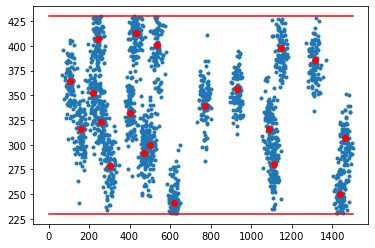

In [238]:
plt.plot(AxonsAllNew[:2000,0], AxonsAllNew[:2000,2], '.',
         somas[:20,0], somas[:20,2], 'or',
         [0, 1500], [230, 230], 'r',
         [0, 1500], [430, 430],'r')

In [229]:
somas = np.loadtxt('test_data/MLI_20000/MLIcoordinates.dat')

In [230]:
somas.shape

(19885, 3)

In [231]:
somas=somas[0:100]

In [239]:
print(somas[:,0].min(), somas[:,0].max())
print(somas[:,1].min(), somas[:,1].max())
print(somas[:,2].min(), somas[:,2].max())

4.2095505579908306 1489.4020292083399
0.12854103652016136 697.4361825130925
233.49482242584656 427.11204507480795


In [240]:
print(len(outMinus)+ len(outPlus))
somas.shape

618


(100, 3)

In [241]:
#CONTROL check if out of Layer Plus correction (z-Axis)
outPlusC=[]
outMinusC=[]
upperLimit=max(somas[:,2])+10
lowerLimit=min(somas[:,2])-10
for i in range(AxonsAllNew.shape[0]):
    #print(i)
    if AxonsAllNew[i,2]>upperLimit:
        outPlusC.append(i)                
    elif AxonsAllNew[i,2]< lowerLimit:
        outMinusC.append(i)
        

In [242]:
print(max(somas[:,2]), min(somas[:,2]))

427.11204507480795 233.49482242584656


In [243]:
print("#Axons out at upper layer:",len(outPlus),
      ", #Axons out at lower layer:", len(outMinus),
     "In total Out:" ,(len(outPlus)+len(outMinus)),
     ", From overall:", AxonsAll.shape[0] )

#Axons out at upper layer: 316 , #Axons out at lower layer: 302 In total Out: 618 , From overall: 10000


In [244]:
#Find coordinated which have been changed
AxOutCoordAll=np.empty((0,3), dtype=object)
for i in range(len(outPlus)):
    AxOutCoord = AxonsAll[outPlus[i]]
    AxOutCoordAll = np.vstack((AxOutCoordAll, AxOutCoord))
    
    
for i in range(len(outMinus)):
    AxOutCoord = AxonsAll[outMinus[i]]
    AxOutCoordAll = np.vstack((AxOutCoordAll, AxOutCoord))
     

In [245]:
max(somas[:,2])

427.11204507480795

In [246]:
print(upperLimit)
print(lowerLimit)

437.11204507480795
223.49482242584656


In [247]:
min(AxOutCoordAll[:,2])

177.22900026523337

In [248]:
AxOutCoordAll.shape


(618, 3)

100%|██████████| 360/360 [00:53<00:00,  6.71it/s]


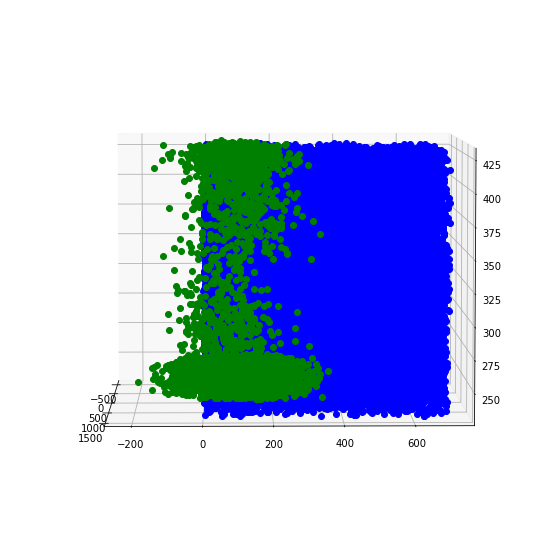

In [22]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
#ax.plot(AxonsAll[:,0], AxonsAll[:,1], AxonsAll[:,2],'og')
ax.plot(somas[:,0], somas[:,1], somas[:,2],'ob')
#ax.plot(somas[:,0]+200, somas[:,1]+200, somas[:,2]+200,'oc')#borders
#ax.plot(somas[:,0]-200, somas[:,1]-200, somas[:,2]-200,'oc')#borders
#ax.plot(AxOutCoordAll[:,0], AxOutCoordAll[:,1], AxOutCoordAll[:,2],'oc')
ax.plot(AxonsAllNew[:,0], AxonsAllNew[:,1], AxonsAllNew[:,2],'og')



for ii in trange(0,360,1):
    ax.view_init(elev=5., azim=ii)
    plt.savefig("movie_figs/movie%d.png" % ii)

[260.49691676 240.67988039 322.96117708]


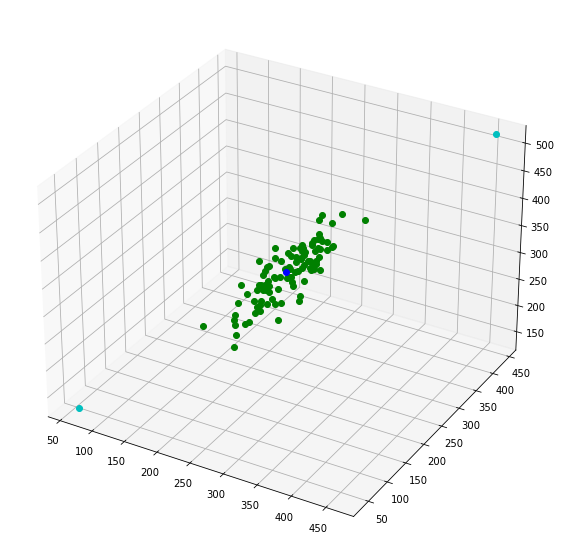

In [249]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(AxonsAll[0:100,0], AxonsAll[0:100,1], AxonsAll[0:100,2],'og')
ax.plot(somas[0:1,0], somas[0:1,1], somas[0:1,2],'ob')
ax.plot(somas[0:1,0]+200, somas[0:1,1]+200, somas[0:1,2]+200,'oc')
ax.plot(somas[0:1,0]-200, somas[0:1,1]-200, somas[0:1,2]-200,'oc')



print(somas[0])

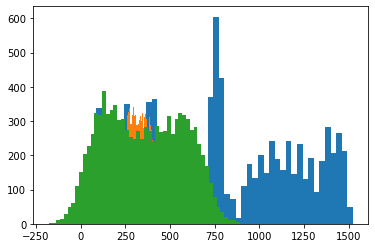

In [250]:
plt.hist(AxonsAll[:,0],50);
plt.hist(AxonsAll[:,2],50);
plt.hist(AxonsAll[:,1],50);





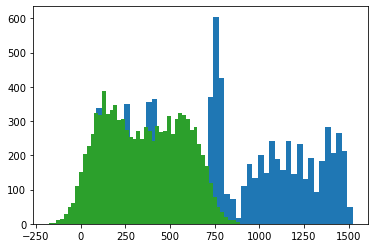

In [251]:
plt.hist(AxonsAllNew[:,0],50);
plt.hist(AxonsAllNew[:,2],50);
plt.hist(AxonsAllNew[:,1],50);


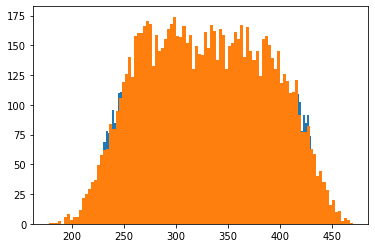

In [252]:
plt.hist(AxonsAllNew[:,2],100);
plt.hist(AxonsAll[:,2],100);

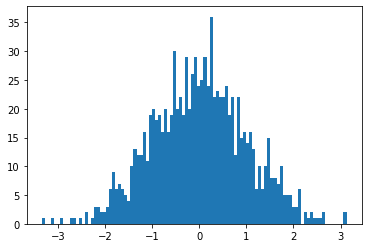

In [253]:
nsamples = np.random.randn(1000)
plt.hist(nsamples,100);

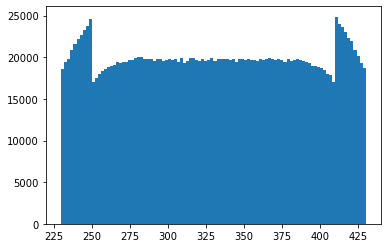

In [48]:
plt.hist(AxonsAllNew[:,2],100);

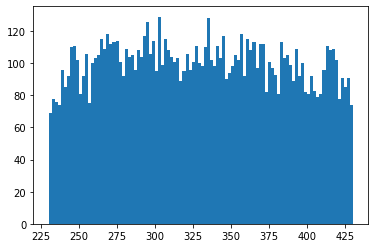

In [254]:
plt.hist(AxonsAllNew[:,2],100);

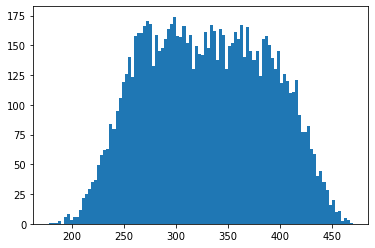

In [255]:
plt.hist(AxonsAll[:,2],100);

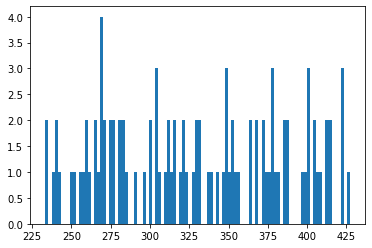

In [256]:
plt.hist(somas[:,2],100);

## Running script with Neuron

In [ ]:
cd ComputationalNeuroscienceUnit/pycabnn-MLI/

In [ ]:
soma = np.zeros((60,3))
somas = np.array([np.random.uniform(-600,600,3) for i in soma]) # cos=x; sin=y
somas[:,0] = np.random.uniform(-600, 600, size=60)
somas[:,1] = np.random.uniform(20, 180, size=60)


print("We generated", len(somas), "somas.")

In [ ]:
somas.shape

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pycabnn.cell_population as pop

In [ ]:
from neuron import h
h.load_file('test_data/params/Parameters.hoc')

In [ ]:
h.MLI_dend_length

In [ ]:
mlipop = pop.MLI_pop(h)

In [ ]:
type(mlipop)

In [ ]:
dir(mlipop)

In [ ]:
DendPointAllAll, dendpt_ids_all, segs = mlipop.gen_dendrite(somas, return_end_points=False)

In [ ]:
21600/4/90

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
# ax.plot(somas[0,0], somas[0,1], somas[0,2],'og')

for i in range(90*4,90*4*2):
    if segs[i,1]== 0:
        ax.plot(DendPointAllAll[i,0], DendPointAllAll[i,1],DendPointAllAll[i,2],"or", markersize=1)
    else:
        ax.plot(DendPointAllAll[i,0], DendPointAllAll[i,1],DendPointAllAll[i,2],"ok", markersize=1)

In [ ]:
segs[:(360+360):45,:]
segs[:(90),:]

In [ ]:
DendPointAllAll.shape, dendpt_ids_all.shape, segs.shape

In [ ]:
import os
x = np.arange(10)
y = np.arange(11, 20)
print("Original arrays:")
print(x)
print(y)
np.savez('temp_arra.npz', x=x, y=y)
print("Load arrays from the 'temp_arra.npz' file:")
with np.load('temp_arra.npz') as data:
    x2 = data['x']
    y2 = data['y']
    print(x2)
    print(y2)

In [ ]:
ls